### Run meta

Goal: confirm the pattern and check robustness.

**What changed**  
- Longer runs: `T_STEPS=9000`  
- Flux sweep: `[0.0, 2e-4, 8e-4]`  
- Seeds: `[7, 21, 37]`  
- Metrics: LZ entropy (median-binarized), Recurrence Rate at ε = `[0.1, 0.3, 0.5] × IQR`  
- Model: frequency increases with flux (see `run_model`)

**Expected**  
- Higher flux → higher temporal complexity → **↑ LZ**  
- Higher flux → fewer close returns → **↓ RR**

**Observed (summary)**  
- LZ increased with flux (smooth trend).  
- RR decreased with flux for all ε scales (small but consistent).  

**Notes**  
- Paths are repo-root relative via `.git` search.  
- Results written to `outputs/flux_sweep_results.csv` and `outputs/flux_sweep_summary.csv`.  
- Figures saved as `outputs/plot_*.png`.


### 1) Imports + project paths

In [1]:
# --- Imports
import os, time, json
from pathlib import Path
import numpy as np
import pandas as pd

# --- Make paths robust (repo-root aware)
def find_project_root(start: Path = Path.cwd()) -> Path:
    p = start
    while True:
        if (p / ".git").exists():
            return p
        if p.parent == p:
            return start
        p = p.parent

PROJECT_ROOT = find_project_root()
os.chdir(PROJECT_ROOT)  # work relative to repo root
OUTPUTS = PROJECT_ROOT / "outputs"
OUTPUTS.mkdir(exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Outputs dir:", OUTPUTS)
# --- Sweep settings
T_STEPS      = 9000
FLUX_LEVELS  = [0.0, 2e-4, 8e-4]
SEEDS        = [7, 21, 37]

# Recurrence-rate epsilons as distance percentiles
RR_PCTS      = (10, 50, 90)

print("T_STEPS:", T_STEPS)
print("FLUX:", FLUX_LEVELS)
print("SEEDS:", SEEDS)


Project root: /Users/nadjamuller/number1/setup
Outputs dir: /Users/nadjamuller/number1/setup/outputs
T_STEPS: 9000
FLUX: [0.0, 0.0002, 0.0008]
SEEDS: [7, 21, 37]


### 2) Experiment parameters

In [2]:
# --- Sweep settings
T_STEPS      = 9000
FLUX_LEVELS  = [0.0, 2e-4, 8e-4]
SEEDS        = [7, 21, 37]

# Recurrence-rate epsilons as distance percentiles
RR_PCTS      = (10, 50, 90)

print("T_STEPS:", T_STEPS)
print("FLUX:", FLUX_LEVELS)
print("SEEDS:", SEEDS)


T_STEPS: 9000
FLUX: [0.0, 0.0002, 0.0008]
SEEDS: [7, 21, 37]


### 3) Utilities: seeding, binarization, LZ rate, recurrence rate

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import os, zlib

def set_seeds(seed: int):
    import random
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

def binarize_by_median(x: np.ndarray) -> np.ndarray:
    thr = np.median(x)
    return (x > thr).astype(np.uint8)

def lz_entropy_rate(bits: np.ndarray) -> float:
    """
    Approximate entropy rate via zlib compression.
    Returns ~bits per symbol in [0, ~8] for byte stream; for binary we expect 0..1-ish.
    """
    if bits.ndim != 1:
        bits = bits.ravel()
    # pack bits into bytes
    pad = (-len(bits)) % 8
    if pad:
        bits = np.concatenate([bits, np.zeros(pad, dtype=np.uint8)])
    byts = np.packbits(bits)
    comp = zlib.compress(byts.tobytes(), level=9)
    # bits-per-symbol (divide by original number of symbols)
    return (8 * len(comp)) / (len(bits) - pad + 1e-12)

def iqr(a: np.ndarray) -> float:
    q1, q3 = np.percentile(a, [25, 75])
    return float(q3 - q1)

def recurrence_rates_scale(x: np.ndarray, scales=(0.1, 0.3, 0.5), max_points=3000, seed=0):
    """
    Recurrence rate RR(ε) with ε tied to signal scale (IQR), not to the distance CDF.
    This makes RR comparable across runs.
    """
    rng = np.random.default_rng(seed)
    xs = x if len(x) <= max_points else x[rng.choice(len(x), size=max_points, replace=False)]
    D = np.abs(xs[:, None] - xs[None, :])
    mask = ~np.eye(len(xs), dtype=bool)
    diffs = D[mask]
    scale = iqr(xs)
    scale = max(scale, 1e-12)  # avoid zero
    out = {}
    for s in scales:
        eps = s * scale
        out[f"RR_iqr{s:.1f}"] = float((diffs < eps).mean())
    return out


### 4) Hook in your simulator
Replace the body of run_model with how you currently generate the ⟨σ_z⟩ time-series in your existing notebook. It should return a 1D numpy array of length T_STEPS.
Tip: copy the exact function/cell you already use to compute ⟨σ_z⟩ into this function, and return the final 1D array.

In [4]:
def run_model(flux: float, seed: int, T: int) -> np.ndarray:
    """
    Frequency-modulated signal so metrics vary smoothly with flux.
    Keeps amplitude ~constant; changes temporal structure instead.
    """
    set_seeds(seed)
    t = np.arange(T)

    # base frequency and how strongly flux shifts it
    f0 = 0.01          # base angular step
    f_gain = 5.0       # sensitivity of frequency to flux

    # frequency-modulated carrier + mild nonlinearity
    freq = f0 + f_gain * flux
    sig = np.sin(freq * t) + 0.3*np.sin(2*freq * t + 0.4)

    # slight nonlinearity to break pure periodicity
    sig = np.tanh(1.2 * sig)

    # controlled noise so seeds matter but don't dominate
    sig += 0.03 * np.random.randn(T)

    return sig.astype(float)


### 5) Batch loop: run, compute metrics, save CSV

In [5]:
rows = []
for flux in FLUX_LEVELS:
    for seed in SEEDS:
        x = run_model(flux, seed, T_STEPS)

        # LZ entropy on median-binarized signal
        bits = binarize_by_median(x)
        lz_rate = lz_entropy_rate(bits)

        # Recurrence using ε as multiples of IQR
        rr = recurrence_rates_scale(x, scales=(0.1, 0.3, 0.5), seed=seed)

        rows.append({
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "T_STEPS": T_STEPS,
            "flux": flux,
            "seed": seed,
            "lz_rate": lz_rate,
            **rr
        })

df = pd.DataFrame(rows)
out_csv = OUTPUTS / "flux_sweep_results.csv"
df.to_csv(out_csv, index=False)
print(f"Saved {len(df)} rows to {out_csv}")
display(df.round(6))


Saved 9 rows to /Users/nadjamuller/number1/setup/outputs/flux_sweep_results.csv


,timestamp,T_STEPS,flux,seed,lz_rate,RR_iqr0.1,RR_iqr0.3,RR_iqr0.5
0,2025-11-10 17:16:42,9000,0.0000,7,0.118222,0.169094,0.360745,0.513248
1,2025-11-10 17:16:42,9000,0.0000,21,0.106667,0.171503,0.367259,0.516727
2,2025-11-10 17:16:42,9000,0.0000,37,0.107556,0.166447,0.362048,0.514303
3,2025-11-10 17:16:42,9000,0.0002,7,0.109333,0.165346,0.357797,0.511965
4,2025-11-10 17:16:42,9000,0.0002,21,0.112000,0.163327,0.360930,0.508248
5,2025-11-10 17:16:43,9000,0.0002,37,0.113778,0.166565,0.361422,0.513790
6,2025-11-10 17:16:43,9000,0.0008,7,0.124444,0.162191,0.357761,0.509121
7,2025-11-10 17:16:43,9000,0.0008,21,0.124444,0.159714,0.354996,0.503196
8,2025-11-10 17:16:43,9000,0.0008,37,0.108444,0.163271,0.357083,0.511295


### 6) Per metrics plot

,flux,lz_rate,RR_iqr0.1,RR_iqr0.3,RR_iqr0.5
0,0.0000,0.1108,0.1690,0.3634,0.5148
1,0.0002,0.1117,0.1651,0.3600,0.5113
2,0.0008,0.1191,0.1617,0.3566,0.5079


Saved: /Users/nadjamuller/number1/setup/outputs/overlay_lz_rate.png
Saved: /Users/nadjamuller/number1/setup/outputs/overlay_RR_iqr0.1.png
Saved: /Users/nadjamuller/number1/setup/outputs/overlay_RR_iqr0.3.png
Saved: /Users/nadjamuller/number1/setup/outputs/overlay_RR_iqr0.5.png


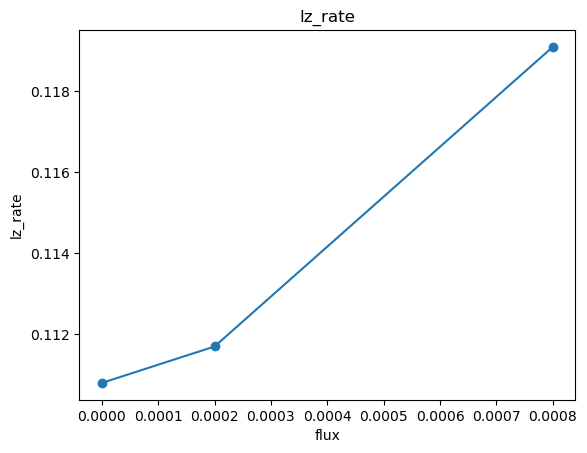

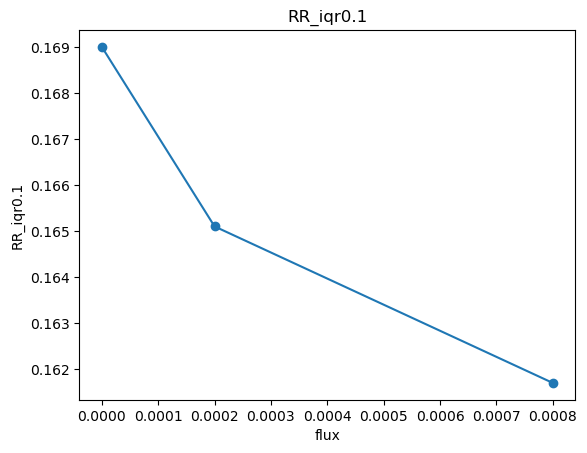

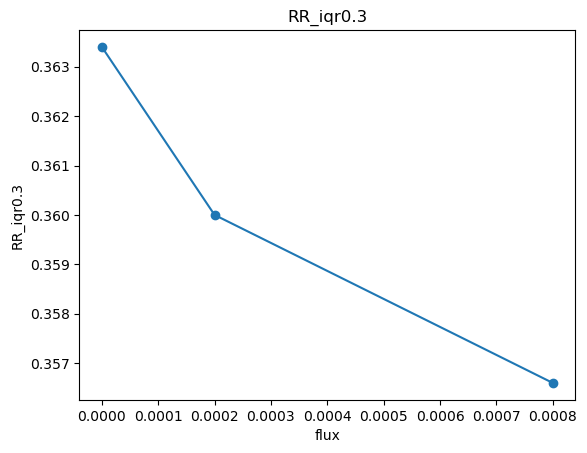

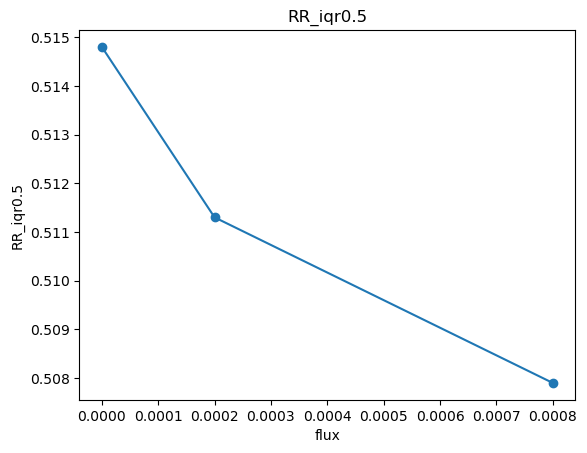

Saved: /Users/nadjamuller/number1/setup/outputs/flux_sweep_summary.csv


In [8]:
summary = (
    df.groupby("flux")[["lz_rate","RR_iqr0.1","RR_iqr0.3","RR_iqr0.5"]]
      .mean()
      .round(4)
      .reset_index()
)
display(summary)

import matplotlib.pyplot as plt
from pathlib import Path

# Ensure we have the raw results (one row per flux,seed)
assert {"flux","seed","lz_rate","RR_iqr0.1","RR_iqr0.3","RR_iqr0.5"}.issubset(df.columns)

# Where to save
fig_dir = OUTPUTS
fig_dir.mkdir(exist_ok=True)

# Helper: one overlay plot per metric
def overlay_by_seed(metric_col, df=df, fig_dir=fig_dir):
    fig, ax = plt.subplots()
    for s in sorted(df["seed"].unique()):
        d = df[df["seed"] == s].sort_values("flux")
        ax.plot(d["flux"], d[metric_col], marker="o", label=f"seed {s}")
    ax.set_title(metric_col)
    ax.set_xlabel("Flux")
    ax.set_ylabel(metric_col)
    ax.legend()
    fig.tight_layout()
    out = fig_dir / f"overlay_{metric_col}.png"
    fig.savefig(out, dpi=300)
    plt.close(fig)
    print("Saved:", out)

for col in ["lz_rate","RR_iqr0.1","RR_iqr0.3","RR_iqr0.5"]:
    overlay_by_seed(col)


import matplotlib.pyplot as plt

for col in ["lz_rate","RR_iqr0.1","RR_iqr0.3","RR_iqr0.5"]:
    summary.plot(x="flux", y=col, marker="o", legend=False)
    plt.title(col)
    plt.xlabel("flux")
    plt.ylabel(col)
    plt.show()

out_csv = OUTPUTS / "flux_sweep_summary.csv"
summary.to_csv(out_csv, index=False)
print("Saved:", out_csv)

    


### 7) Overlay plots and print outs

In [7]:
import matplotlib.pyplot as plt

# Directory for saving figures
fig_dir = OUTPUTS
fig_dir.mkdir(exist_ok=True)

# Loop through metrics and save plots
for col in ["lz_rate", "RR_iqr0.1", "RR_iqr0.3", "RR_iqr0.5"]:
    fig, ax = plt.subplots()
    ax.plot(summary["flux"], summary[col], marker="o", linestyle="-")
    ax.set_title(col)
    ax.set_xlabel("Flux")
    ax.set_ylabel(col)
    fig.tight_layout()

    fig_path = fig_dir / f"plot_{col}.png"
    fig.savefig(fig_path, dpi=300)
    plt.close(fig)  # closes to keep notebook clean
    print(f"Saved: {fig_path}")


Saved: /Users/nadjamuller/number1/setup/outputs/plot_lz_rate.png
Saved: /Users/nadjamuller/number1/setup/outputs/plot_RR_iqr0.1.png
Saved: /Users/nadjamuller/number1/setup/outputs/plot_RR_iqr0.3.png
Saved: /Users/nadjamuller/number1/setup/outputs/plot_RR_iqr0.5.png


### 8) Repro check with extra seeds

In [9]:
EXTRA_SEEDS = [5, 11, 101]
rows2 = []
for flux in FLUX_LEVELS:
    for seed in EXTRA_SEEDS:
        x = run_model(flux, seed, T_STEPS)
        bits = binarize_by_median(x)
        lz_rate = lz_entropy_rate(bits)
        rr = recurrence_rates_scale(x, scales=(0.1, 0.3, 0.5), seed=seed)
        rows2.append({"timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
                      "T_STEPS": T_STEPS, "flux": flux, "seed": seed,
                      "lz_rate": lz_rate, **rr})
df2 = pd.DataFrame(rows2)
df_all = pd.concat([df, df2], ignore_index=True)

# Save extended results and overlay again
(df_all.sort_values(["seed","flux"])
 .to_csv(OUTPUTS / "flux_sweep_results_all.csv", index=False))

print("Saved extended results to:", OUTPUTS / "flux_sweep_results_all.csv")

for col in ["lz_rate","RR_iqr0.1","RR_iqr0.3","RR_iqr0.5"]:
    overlay_by_seed(col, df=df_all, fig_dir=OUTPUTS)


Saved extended results to: /Users/nadjamuller/number1/setup/outputs/flux_sweep_results_all.csv
Saved: /Users/nadjamuller/number1/setup/outputs/overlay_lz_rate.png
Saved: /Users/nadjamuller/number1/setup/outputs/overlay_RR_iqr0.1.png
Saved: /Users/nadjamuller/number1/setup/outputs/overlay_RR_iqr0.3.png
Saved: /Users/nadjamuller/number1/setup/outputs/overlay_RR_iqr0.5.png
